# HR Stay or Leave

<hr>

> Using the unbalanced dataset of employees of the company to predict which employee might stay or leave the company.

> SMOT is used to deal with the unbalanced dataset.

> SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem

<hr>

#### To ignore sklearn warnings

In [1]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

#### Importing Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss, classification_report, confusion_matrix

In [3]:
# For seaborn colors
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### Loading the dataset

In [4]:
df = pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


#### Looking at how much is the dataset imbalanced

0    11428
1     3571
Name: left, dtype: int64


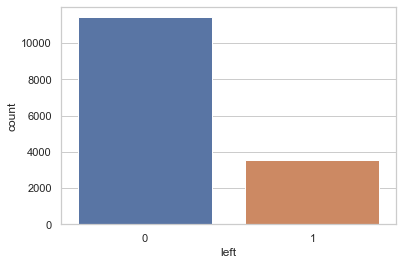

In [5]:
print(df['left'].value_counts())

sns.countplot(x='left', data=df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Working with **ordinal data** like the salary coloumn

In [7]:
replacement = {
    'low': 0,
    'medium': 1,
    'high': 2
}

df.salary = df.salary.apply(lambda x: replacement[x])

In [8]:
df.salary[:5]

0    0
1    1
2    1
3    0
4    0
Name: salary, dtype: int64

### Working with nominal data like Deparment column

In [9]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

dept_ohe_df = pd.DataFrame(df.Department)
dept_ohe_df = pd.DataFrame(ohe.fit_transform(dept_ohe_df[['Department']]).toarray())

In [10]:
dept_ohe_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
print(f'Unique Departments: {len(df.Department.unique())}')

Unique Departments: 10


In [12]:
col_names = []
for col_name in ohe.get_feature_names():
    col_name = col_name.split('_')[1]
    col_names.append(col_name)
    
col_names

['IT',
 'RandD',
 'accounting',
 'hr',
 'management',
 'marketing',
 'product',
 'sales',
 'support',
 'technical']

In [13]:
dept_ohe_df.columns = col_names
dept_ohe_df.head()

,IT,RandD,accounting,hr,management,marketing,product,sales,support,technical
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Removing one column from "dep_ohe_df" to avoid multi-corrliearity

In [14]:
dept_ohe_df = dept_ohe_df.drop(['IT'], axis='columns')
dept_ohe_df.head()

,RandD,accounting,hr,management,marketing,product,sales,support,technical
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Target Column

In [15]:
y = df[['left']]
y.head()

,left
0,1
1,1
2,1
3,1
4,1


#### Adding the ohe results and removing 'left' column

In [16]:
df = df.drop(['Department', 'left'], axis='columns')
df = pd.concat([dept_ohe_df, df], axis='columns')
df.head()

,RandD,accounting,hr,management,marketing,product,sales,support,technical,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.38,0.53,2,157,3,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.80,0.86,5,262,6,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.11,0.88,7,272,4,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.72,0.87,5,223,5,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.37,0.52,2,159,3,0,0,0


In [17]:
X = df.copy()

<hr>

## Balancing the unbalanced data

#### Creating train and test datasets using X and y

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#### Creating train and cross-validation datasets using the X_train and y_train

In [19]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

Splitting the train dataset into train and cross validation data sets before oversampling to avoid oversampling to bleed data for cross_val_score

#### Oversampling to balance the data

In [20]:
_smote = SMOTE(random_state=0)

sm_cols = X_train.columns

X_train, y_train = _smote.fit_sample(X_train, y_train)
X_train = pd.DataFrame(data=X_train, columns=sm_cols)
y_train = pd.DataFrame(data=y_train, columns=['left'])

# We can Check the numbers of our data
print("Length of oversampled data is", len(X_train))
print("Number of left no", len(y_train[y_train['left']==0]))
print("Number of left yes", len(y_train[y_train['left']==1]))
print("Proportion of left no data in oversampled data is", len(y_train[y_train['left']==0])/len(X_train))
print("Proportion of left yes data in oversampled data is", len(y_train[y_train['left']==1])/len(X_train))

Length of oversampled data is 12838
Number of left no 6419
Number of left yes 6419
Proportion of left no data in oversampled data is 0.5
Proportion of left yes data in oversampled data is 0.5


<hr>

## Featrue Selection

#### Using Pearson Correlation

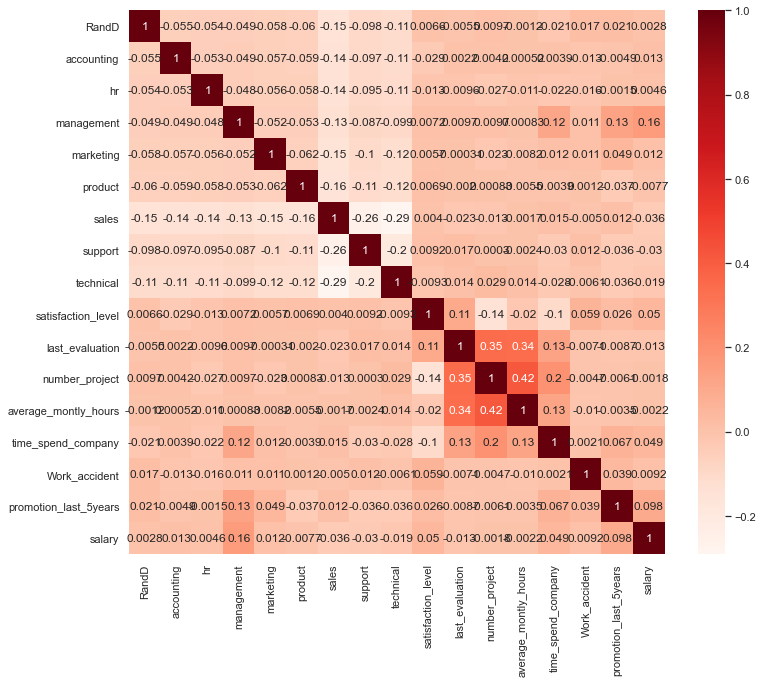

In [21]:
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Cross Validation

Using the cross validation set to perform cross validation

In [22]:
skf = StratifiedKFold(n_splits=10, random_state=0)

In [23]:
col_names.remove('IT') # since IT is dropped
col_names

['RandD',
 'accounting',
 'hr',
 'management',
 'marketing',
 'product',
 'sales',
 'support',
 'technical']

In [24]:
X_cv = np.array(X_cv)
X_cv = X_cv.astype('int')
y_cv = np.array(y_cv)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [26]:
models = [
    LogisticRegression(), 
    SGDClassifier(), 
    KNeighborsClassifier(), 
    GaussianNB(), 
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
]

In [27]:
def cross_val_score(models, X_cv, y_cv):
    for model in models:
        scores = []
        for train, test in skf.split(X_cv, y_cv):
            X_train, X_test = X_cv[train], X_cv[test]
            y_train, y_test = y_cv[train], y_cv[test]

            _smote = SMOTE(random_state=0)
            X_train_sm, y_train_sm = _smote.fit_sample(X_train, y_train)

            model.fit(X_train_sm, y_train_sm)

            score = model.score(X_test, y_test)        
            scores.append(score)

        print(f'== {model} ==')
        print(f'Cross-Validation mean-score: {np.mean(score)}')
        print()
        
cross_val_score(models, X_cv, y_cv)

== LogisticRegression() ==
Cross-Validation mean-score: 0.7380952380952381

== SGDClassifier() ==
Cross-Validation mean-score: 0.2571428571428571

== KNeighborsClassifier() ==
Cross-Validation mean-score: 0.8904761904761904

== GaussianNB() ==
Cross-Validation mean-score: 0.5666666666666667

== MultinomialNB() ==
Cross-Validation mean-score: 0.680952380952381

== DecisionTreeClassifier() ==
Cross-Validation mean-score: 0.9285714285714286

== RandomForestClassifier() ==
Cross-Validation mean-score: 0.9523809523809523

== SVC() ==
Cross-Validation mean-score: 0.7238095238095238



### Recursive Feature Elimination

In [28]:
rfe = RandomForestClassifier()

rfe = RFE(rfe, 5)
rfe.fit(X_train, y_train.values.ravel())

selector = rfe.support_

print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False  True  True  True
  True  True False False False]
[ 8  9  7 11 10 12  5  6  4  1  1  1  1  1  3 13  2]


<hr>

Here we took RandomForestClassifier model with 5 features and RFE gave feature ranking as above, but the selection of number ‘5’ was random. Now we need to find the optimum number of features, for which the accuracy is the highest. We do that by using loop starting with 1 feature and going up to 18. We then take the one for which the accuracy is highest.

<hr>

In [29]:
len(X.columns)

17

In [30]:
def rfe(model, X_cv, y_cv):
    # number of features
    nof_list = np.arange(1, 18)
    high_score = 0
    
    # variable to store the optimum features
    nof = 0
    score_list = []
    
    for n in range(len(nof_list)):
        X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.3, random_state=0)

        _smote = SMOTE(random_state=0)
        X_train_sm, y_train_sm = _smote.fit_sample(X_train, y_train)

        rfe = RFE(model, nof_list[n])
        X_train_rfe = rfe.fit_transform(X_train_sm, y_train_sm)
        X_test_rfe = rfe.transform(X_test)
        
        model.fit(X_train_rfe, y_train_sm)
        
        score = model.score(X_test_rfe, y_test)        
        score_list.append(score)
        
        if score > high_score:
            high_score = score
            nof = nof_list[n]
    
    return (nof, high_score)

nof, high_score = rfe(RandomForestClassifier(), X_cv, y_cv)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 12
Score with 12 features: 0.938095


<hr>

As seen from above code, the optimum number of features is 16. We now feed 16 as number of features to RFE and get the final set of features given by RFE method, as follows

<hr>

#### Performing Feature Elimination

In [31]:
model = RandomForestClassifier()

rfe = RFE(model, 12)
rfe.fit(X_train, y_train.values.ravel())

selector = rfe.support_

print(rfe.support_)
print(rfe.ranking_)

[False  True  True False False False  True  True  True  True  True  True
  True  True  True False  True]
[2 1 1 4 3 5 1 1 1 1 1 1 1 1 1 6 1]


#### Selected Features

In [32]:
col = (X_train.columns)

import itertools

result = itertools.compress(col, selector)

col_names = []
for c in result:
    col_names.append(c)
    print(c)

accounting
hr
sales
support
technical
satisfaction_level
last_evaluation
number_project
average_montly_hours
time_spend_company
Work_accident
salary


In [33]:
X_train = X_train[col_names]
X_test = X_test[col_names]

len(col_names)

12

#### Implementing the model

In [34]:
cols = col_names.copy()

X_train = X_train[cols]
y_train = y_train['left']

logit_model = sm.Logit(y_train, X_train)

result = logit_model.fit()

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.499618
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.279     
Dependent Variable:   left              AIC:               12852.1868
Date:                 2020-05-18 18:44  BIC:               12941.7087
No. Observations:     12838             Log-Likelihood:    -6414.1   
Df Model:             11                LL-Null:           -8898.6   
Df Residuals:         12826             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
accounting            0.3965   0.1117   3.5509 0.0004  0.1776  0.6153
hr              

Every Feature that we got from Recursive Feature Elimination is selected since no feature's p-value is greater that 0.05.

<hr>

## Creating the model

#### Parameter Tuning

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
def rt_param_selection(X, y, nfolds):
    criterion = ['gini', 'entropy']
    max_features = ['auto', 'sqrt', 'log2']

    param_grid = {
        'criterion': criterion, 
        'max_features': max_features
    }

    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_estimator_
    return grid_search.best_estimator_

skf = StratifiedKFold(n_splits=10)
best_params_ = rt_param_selection(X_train, y_train, skf)
best_params_

RandomForestClassifier()

#### Cross Validation

In [37]:
cross_val_score([RandomForestClassifier(criterion='entropy')], X_cv, y_cv)

== RandomForestClassifier(criterion='entropy') ==
Cross-Validation mean-score: 0.9333333333333333



#### Learning Curve

In [38]:
from sklearn.model_selection import learning_curve

_size = np.arange(0.01, 1.01, 0.01)
train_sizes = np.array(_size)
scoring = 'neg_mean_squared_error'

train_sizes_abs, train_scores, cv_scores = learning_curve(RandomForestClassifier(criterion='entropy'), X_train, y_train, train_sizes=train_sizes, cv=skf, scoring=scoring)

In [39]:
train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)

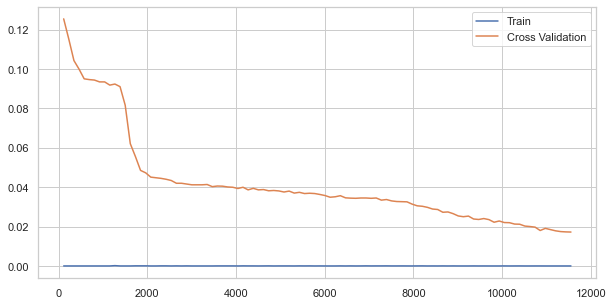

In [40]:
f, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_sizes_abs, train_scores_mean, label='Train')
ax.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

ax.legend()

#### Feature Scaling

In [41]:
scaler = StandardScaler()

X_train = scaler.fit_transform(np.asanyarray(X_train))
y_train = np.asanyarray(y_train)

X_test = scaler.fit_transform(np.asanyarray(X_test))
y_test = np.asanyarray(y_test)

#### Fitting the model

In [42]:
model = RandomForestClassifier(criterion='entropy')
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

#### Predictions

In [43]:
y_test_pred = model.predict(X_test)
print(y_test_pred)
print()
print(f"Prediction: \n{pd.DataFrame(y_test_pred)[0].value_counts()}")

[0 1 0 ... 1 0 0]

Prediction: 
0    3407
1    1093
Name: 0, dtype: int64


In [44]:
print(y_test.reshape(1, -1)[0])
print()
print(f"Actual: \n{pd.DataFrame(y_test)[0].value_counts()}")

[0 1 0 ... 1 0 0]

Actual: 
0    3408
1    1092
Name: 0, dtype: int64


In [45]:
y_test_prob = model.predict_proba(X_test)
y_test_prob

array([[0.86, 0.14],
       [0.38, 0.62],
       [0.96, 0.04],
       ...,
       [0.  , 1.  ],
       [0.86, 0.14],
       [0.75, 0.25]])

#### Evaluating Model

In [46]:
print(f'Model Score: {model.score(X_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9206666666666666
f1-score: 0.9206790002535127
precision score: 0.920691449792164
recall score: 0.9206666666666666


In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(confusion_matrix(y_test, y_test_pred, labels=[1,0]))

[[ 914  178]
 [ 179 3229]]


Confusion matrix, without normalization
[[ 914  178]
 [ 179 3229]]


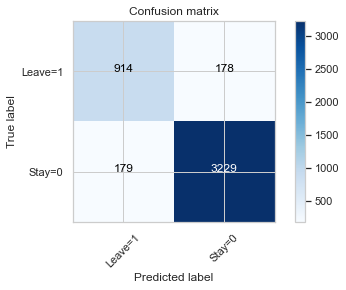

In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Leave=1','Stay=0'], normalize= False,  title='Confusion matrix')

In [49]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3408
           1       0.84      0.84      0.84      1092

    accuracy                           0.92      4500
   macro avg       0.89      0.89      0.89      4500
weighted avg       0.92      0.92      0.92      4500



#### ROC Curve

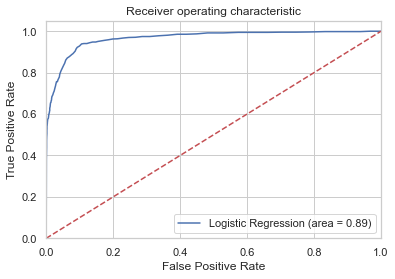

In [50]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# The blue farther from red-dotted the better model

#### Pipeline

In [54]:
from sklearn.pipeline import Pipeline

In [56]:
scaling = ('scale', StandardScaler())
model = ('model', RandomForestClassifier(criterion='entropy'))

# Steps in the pipeline
steps = [scaling, model]

pipe = Pipeline(steps=steps)

# Fiitting the model
model = pipe.fit(X_train, y_train)

# Out-Of-Sample Forecast
y_test_pred = model.predict(X_test)

# Evaluation
print(f'Model Score: {model.score(X_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9191111111111111
f1-score: 0.9188296805403625
precision score: 0.9186048917831485
recall score: 0.9191111111111111


#### Precision-Recall vs Threshold Chart

(0.0, 1.0)

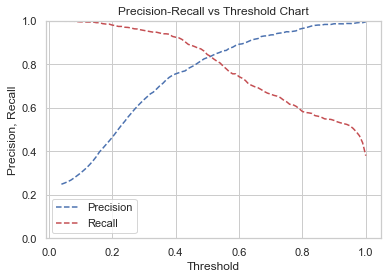

In [51]:
log_pred_y = model.predict(X_test) 

log_probs_y = model.predict_proba(X_test) 

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, log_probs_y[:, 1]) 
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

#### To control the threshold of probability abpve which we want to consider it has true.

Confusion matrix, without normalization
[[ 963  129]
 [ 247 3161]]
                      0
accuracy       0.916444
recall         0.881868
precision      0.795868
f1_score       0.836664
roc_auc_score  0.904696


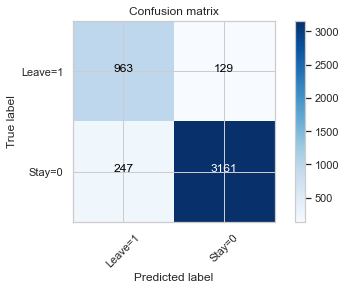

In [52]:
THRESHOLD = 0.45
preds = np.where(model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

results = pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds), precision_score(y_test, preds), f1_score(y_test, preds), roc_auc_score(y_test, preds)], index=["accuracy", "recall", "precision", "f1_score", "roc_auc_score"])

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Leave=1','Stay=0'], normalize= False,  title='Confusion matrix')

print(results)

#### Saving the model

In [53]:
from joblib import dump

dump(model, 'model.joblib')

['model.joblib']

<hr>